[source](https://www.datasklr.com/logistic-regression/multinomial-logistic-regression)

In [1]:
import rpy2.rinterface
import rpy2.robjects as robjects

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.regressionplots as smgr
from sklearn.metrics import confusion_matrix, accuracy_score

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 75
plt.rcParams['font.size'] = 12
sns.set_theme(style="whitegrid")
sns.set_theme(color_codes=True)
sns.set_context("poster")
%load_ext rpy2.ipython

In [2]:
%%R -o df
load('sem4.RData')
df = uk

In [3]:
# Selecting only usable data and removing NA's
df = df[['prvote', 'age', 'sex', 'income1', 'edu']].dropna()
# Recoding category to numeric
df['prvote_code'] = df.prvote.cat.codes
print(pd.DataFrame({'code': [0, 1, 2, 3], 'name': df.prvote.cat.categories}).set_index('code'))

                  name
code                  
0         Conservative
1               Labour
2     Liberal Democrat
3                Other


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1265 entries, 3 to 2422
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   prvote       1265 non-null   category
 1   age          1265 non-null   float64 
 2   sex          1265 non-null   category
 3   income1      1265 non-null   float64 
 4   edu          1265 non-null   float64 
 5   prvote_code  1265 non-null   int8    
dtypes: category(2), float64(3), int8(1)
memory usage: 43.6+ KB


# Predict which party was supported by age, gender, income group, and education

In [5]:
model = smf.mnlogit(formula='prvote_code ~ age + sex + income1 + edu', data=df).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 1.269979
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:            prvote_code   No. Observations:                 1265
Model:                        MNLogit   Df Residuals:                     1250
Method:                           MLE   Df Model:                           12
Date:                 Вс, 07 фев 2021   Pseudo R-squ.:                 0.02096
Time:                        18:43:08   Log-Likelihood:                -1606.5
converged:                       True   LL-Null:                       -1640.9
Covariance Type:            nonrobust   LLR p-value:                 5.427e-10
prvote_code=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.7062      0.468      3.645      0.000       0.789       2.624
sex[T.Female]    -0.

# Interpret coefficients

In [6]:
print(model.pvalues < 0.05)

                   0      1      2
Intercept       True  False   True
sex[T.Female]  False  False  False
age             True   True   True
income1         True   True   True
edu            False   True  False


### P-values
Model is only 'partly significant' in terms of its effects significance:
- effect of **gender** is not significant in any submodel
- effects of **age** and **income level** are significant in each submodel
- in the second submodel even **intercept** is not significant
- and effect of **education** is significant only for the second submodel

In [7]:
# Odds Ratio
odds = round(np.exp(model.params), 3)
odds.columns = df.prvote.cat.categories[1:]
print(odds)

               Labour  Liberal Democrat  Other
Intercept       5.508             1.651  3.855
sex[T.Female]   0.931             1.024  0.701
age             0.982             0.982  0.977
income1         0.851             0.905  0.815
edu             1.004             1.043  0.987


### Odds ratio
*'Conservative' as reference group* - read each statement as: "__party__ by __value__ *comparing with 'Conservative'* "

- sex=Female: changing **sex** `from Male to Female` *lol* is not significant in any submodel
- age: increase in one unit of age multiplies odds of voting for:
    - 'Labour' by 0.982
    - 'Liberal Democrat' by 0.982
    - 'Other' by 0.977

`Age` have exactly the same effect in each submodel.

- income1: increase in one unit (*level*) of **income** levels multiplies odds of voting for:
    - 'Labour' by 0.851
    - 'Liberal Democrat' by 0.905
    - 'Other' by 0.815
- edu: increase in one unit of **years of education** multiplies odds of voting for:
    - *not significant*
    - 'Liberal Democrat' by 1.043
    - *not significant*

In [8]:
# Average Marginal Effects
print(model.get_margeff().summary().tables[1])

prvote_code=0      dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
sex[T.Female]     0.0171      0.027      0.642      0.521      -0.035       0.069
age               0.0042      0.001      4.770      0.000       0.002       0.006
income1           0.0321      0.005      6.545      0.000       0.022       0.042
edu              -0.0035      0.004     -0.910      0.363      -0.011       0.004
---------------------------------------------------------------------------------
prvote_code=1      dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
sex[T.Female]    -0.0054      0.026     -0.208      0.835      -0.057       0.046
age              -0.0019      0.001     -2.206      0.027      -0.003      -0.000
income1          -0.0205      0.005     -4.234      0.000      -0.030      -0.011
edu             

### Average Marginal Effects
Well, it's a lot of to describe:
- sex=Female: still not significant in any submodel
- age: increase in one unit of age **decreases** the probability of voting for:
    - 'Labour' by 0.0019%
    - 'Liberal Democrat' by 0013%
    - 'Other' by 0.0010%

`Age` have nearly the same effect in each submodel.

- income1: increase in one unit (*level*) of **income** levels **decreases** the probability of voting for:
    - 'Labour' by 0.0205%
    - 'Liberal Democrat' by 0.0014%
    - 'Other' by 0.0102%
- edu: increase in one unit of **years of education** **increases** th probability of voting for:
    - *not significant*
    - 'Liberal Democrat' by 0.0075%
    - *not significant*

All of those are really small effect sizes.

# Look at the model fit

In [9]:
# Pseudo R^2
print('Pseudo R^2:', model.summary().tables[0][3][3])

Pseudo R^2: 0.02096


Pseudo R-squared is *way lower* than 0.1 which is totally not enough for considering model as good.

In [10]:
# PCP
predicted = [np.where(i == i.max())[0][0] for i in model.predict()]
print('Percentage of Correct Predictions (PCP): ', (round(sum(predicted == df.prvote_code)/len(df)*100, 1)), '%', sep='')
# or
print('Accuracy (aka PCP): ', round(accuracy_score(df['prvote_code'], predicted), 3)*100, '%', sep='')

Percentage of Correct Predictions (PCP): 40.8%
Accuracy (aka PCP): 40.8%


Meh, could be better - but still OK, because here are not binary prediction (maybe for such task will be more suitable to use PCA or CFA or some clusterization techniques)

In [11]:
# Real x Predicted
pd.DataFrame(np.array(confusion_matrix(df['prvote_code'], predicted)), 
             index=df.prvote.cat.categories, columns=df.prvote.cat.categories+'_pred')

,Conservative_pred,Labour_pred,Liberal Democrat_pred,Other_pred
Conservative,328,120,3,0
Labour,205,182,10,0
Liberal Democrat,168,120,6,0
Other,64,58,1,0


Well, **others** is really underpredicted - zero at interception.

Overall, model just loves conservatives and tries to set any observation to than group.

# Make a plot to illustrate the relationship between education and party preferences

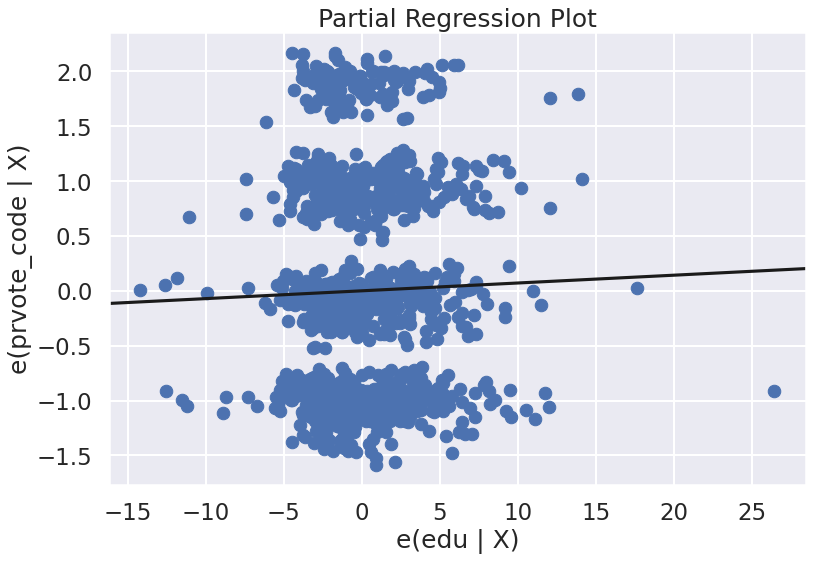

In [12]:
sm.graphics.plot_partregress(endog='prvote_code', exog_i='edu', exog_others=['age', 'sex', 'income1'], data=df, obs_labels=False);

As already known from metrics **years of education** slightly increases probability to vote for 'Liberal Democrats' in comparisong of voting for 'Conservatives'

# Consider theoretical explanations of the results

Great, but how I'm going to do it when I don't have any theory, RQ's or hypotheses?

OK, firstly - people became more conservative with years of age, but became more liberal with years of education. Such results is kinda obvious - elderly people are more conservative, educated ones - more liberal.  
Secondly, people with more income tends to be more conservative - I suppose here will be great to look at interaction of income and age in further elaboration of the model.  
Finally - multinomial logistic regression is not the best choice for such data and better to use some clusterization techniques (although *logistic regression is clusterization*)